# Comparative Analysis of 'dag2pag' Implementation with the DAG-to-PAG in Python Package 'causal-learn'


## An issue in the DAG-to-PAG conversion

In [ ]:
from DAGtoPAGPython.DAG_to_PAG import DAG_to_PAG
from fastdag2pag.dag2pag import dag2pag
from fastdag2pag.Random_Graph import ErdosRenyi
import pandas as pd

def causal_learn_to_pcalg(adj: pd.DataFrame) -> pd.DataFrame:
    """
    Convert a causal-learn style adjacency matrix to pcalg style.
    causal-learn: TAIL=-1, ARROW=1, CIRCLE=2, NULL=0
    pcalg:        TAIL=3,  ARROW=2, CIRCLE=1, NULL=0
    """
    mapping = {-1: 3, 1: 2, 2: 1, 0: 0}
    return adj.replace(mapping)

# Generate a random DAG with latent variables
ER_graph_gen = ErdosRenyi(num_nodes=7, expected_degree=2, def_dataframe=True, seed=321)
graph = ER_graph_gen.get_random_graph()
adj = ER_graph_gen.set_latent_nodes(graph, num_latent=1, selection_bias=True, num_sel=1)
latent_nodes = [node for node in adj.columns if node.startswith('L')]
selection_bias_nodes = [node for node in adj.columns if node.startswith('S')]
# Convert DAG to PAG using causal-learn
pag1 = DAG_to_PAG(adj, latent_nodes=latent_nodes, selection_bias_nodes=selection_bias_nodes)
pag1 = causal_learn_to_pcalg(pag1)  # Convert to pcalg style


# Convert DAG to PAG using FastDAG2PAG
pag2 = dag2pag(adj, latent_nodes=latent_nodes, selection_bias=selection_bias_nodes)['PAG.DataFrame']

# Compare the two PAGs equality
print("PAGs are equal:", pag1.equals(pag2))
"""
The not equal may be caused by R3
"""
diff = pag1.compare(pag2, result_names=("causallearn_pag", "my_pag"))
print("Differences between PAGs:")
print(diff)


PAGs are equal: False
Differences between PAGs:
                V4       
   causallearn_pag my_pag
V5             1.0    2.0


In [ ]:
from fastdag2pag.Graph_utils import Mark
import networkx as nx

## check no circle marks in the difference
vars_list = adj.columns.to_list()
DAG = nx.DiGraph(adj)
ancList = {}
for var in vars_list:
    ancList[var] = set(nx.ancestors(DAG, var))
anclist_S = set()
for s in selection_bias_nodes:
    anclist_S |= ancList[s]

for row_label in diff.index:
    for col_label in diff.columns:
        value = diff.at[row_label, col_label]
        mark_symbol = {Mark.TAIL.value: "-", Mark.ARROW.value: ">", Mark.CIRCLE.value: "o"}
        print(f' {col_label[1]}: {row_label}-{mark_symbol[value]}{col_label[0]}')
        if value != Mark.CIRCLE.value:
            # check the mark in the DAG
            if value == Mark.ARROW.value:
                # means col_label[0] is not an ancetor of {row_label} and S
                if (col_label[0] not in ancList[row_label]) and (col_label[0] not in anclist_S):
                    print(f"{col_label[1]} correct")

            if value == Mark.TAIL.value:
                # means col_label[0] is an ancetor of {row_label} or S
                if (col_label[0] in ancList[row_label]) or (col_label[0] in anclist_S):
                    print(f"{col_label[1]} correct")
                    






 causallearn_pag: V5-oV4
 my_pag: V5->V4
my_pag correct
[('V4', 'causallearn_pag'), ('V4', 'my_pag')]


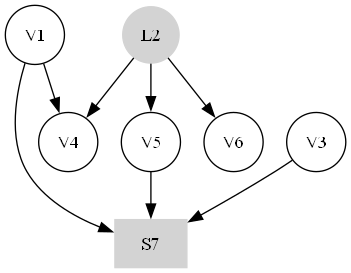

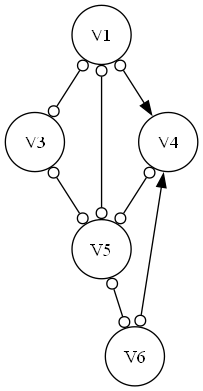

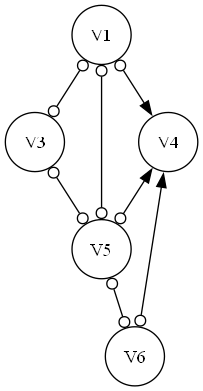

In [2]:
# Visualize the generated DAG and the resulting PAGs from both methods
from fastdag2pag.mixgraph import MixGraph
from IPython.display import Image, display

# Visualize the original DAG
dag = MixGraph()
dag.from_pandas_adjacency(adj, graph_type='DAG')
dag_pydot = dag.to_pydot()
png_bytes = dag_pydot.create_png()
display(Image(png_bytes))  

# Visualize PAG from causal-learn
Pag1 = MixGraph()
Pag1.from_pandas_adjacency(pag1, graph_type='MG')
Pag1_pydot = Pag1.to_pydot()
png_bytes_pag1 = Pag1_pydot.create_png()
display(Image(png_bytes_pag1))  

# Visualize PAG from FastDAG2PAG
Pag2 = MixGraph()
Pag2.from_pandas_adjacency(pag2, graph_type='MG')
Pag2_pydot = Pag2.to_pydot()
png_bytes_pag2 = Pag2_pydot.create_png()
display(Image(png_bytes_pag2))  

In [1]:
from DAGtoPAGPython.DAG_to_PAG import DAG_to_PAG
from fastdag2pag.dag2pag import dag2pag
from fastdag2pag.Random_Graph import ErdosRenyi
import pandas as pd

def causal_learn_to_pcalg(adj: pd.DataFrame) -> pd.DataFrame:
    """
    Convert a causal-learn style adjacency matrix to pcalg style.
    causal-learn: TAIL=-1, ARROW=1, CIRCLE=2, NULL=0
    pcalg:        TAIL=3,  ARROW=2, CIRCLE=1, NULL=0
    """
    mapping = {-1: 3, 1: 2, 2: 1, 0: 0}
    return adj.replace(mapping)

# Generate a random DAG with latent variables
n_nodes = 10
ER_graph_gen = ErdosRenyi(num_nodes=n_nodes, expected_degree=2, def_dataframe=True, seed=321)
num_trials = 10
for trial in range(num_trials):

    # Generate random DAG adjacency matrix
    graph = ER_graph_gen.get_random_graph()
    num_latent = int(n_nodes * 0.1) if n_nodes >= 10 else 1
    num_sel = num_latent
    adj = ER_graph_gen.set_latent_nodes(graph, num_latent=num_latent, selection_bias=True, num_sel=num_sel)
    latent_nodes = [node for node in adj.columns if node.startswith('L')]
    selection_bias_nodes = [node for node in adj.columns if node.startswith('S')]
    # Convert DAG to PAG using causal-learn
    pag1 = DAG_to_PAG(adj, latent_nodes=latent_nodes, selection_bias_nodes=selection_bias_nodes)
    pag1 = causal_learn_to_pcalg(pag1)  # Convert to pcalg style


    # Convert DAG to PAG using FastDAG2PAG
    pag2 = dag2pag(adj, latent_nodes=latent_nodes, selection_bias=selection_bias_nodes)['PAG.DataFrame']

    if trial < 7:
        continue

    # Compare the two PAGs equality
    print("PAGs are equal:", pag1.equals(pag2))
    
    """
    The not equal may be caused by R3
    """
    diff = pag1.compare(pag2, result_names=("causallearn_pag", "my_pag"))
    print("Differences between PAGs:")
    print(diff)
    if trial == 7:
        break









Find uncovered circle path between A and B: V3 o-o V7
Path:  ['V6', 'V8', 'V9']
Orienting edge A - C (Double tail): V3 --- V6
Orienting edge B - D (Double tail): V7 --- V9
Orienting edge (Double tail): V6 --- V8
Orienting edge (Double tail): V8 --- V9
PAGs are equal: False
Differences between PAGs:
                V3                     V6                     V7         \
   causallearn_pag my_pag causallearn_pag my_pag causallearn_pag my_pag   
V3             NaN    NaN             3.0    1.0             3.0    1.0   
V4             3.0    1.0             3.0    1.0             NaN    NaN   
V6             3.0    1.0             NaN    NaN             NaN    NaN   
V7             3.0    1.0             NaN    NaN             NaN    NaN   
V8             3.0    1.0             3.0    1.0             3.0    1.0   
V9             NaN    NaN             NaN    NaN             3.0    1.0   

                V8                     V9         
   causallearn_pag my_pag causallearn_pa

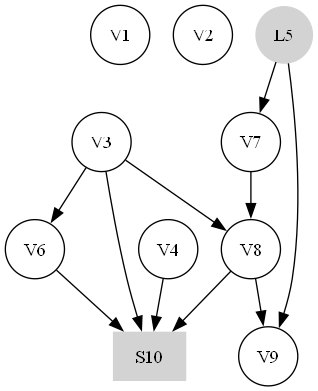

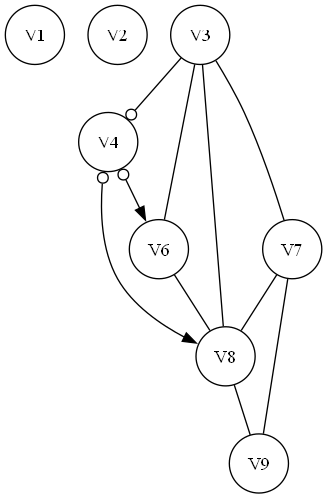

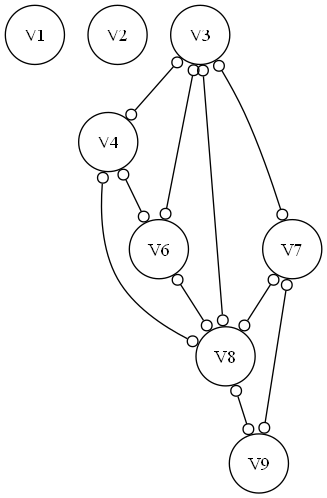

In [2]:
# Visualize the generated DAG and the resulting PAGs from both methods
from fastdag2pag.mixgraph import MixGraph
from IPython.display import Image, display

# Visualize the original DAG
dag = MixGraph()
dag.from_pandas_adjacency(adj, graph_type='DAG')
dag_pydot = dag.to_pydot()
png_bytes = dag_pydot.create_png()
display(Image(png_bytes))  

# Visualize PAG from causal-learn
Pag1 = MixGraph()
Pag1.from_pandas_adjacency(pag1, graph_type='MG')
Pag1_pydot = Pag1.to_pydot()
png_bytes_pag1 = Pag1_pydot.create_png()
display(Image(png_bytes_pag1))  

# Visualize PAG from FastDAG2PAG
Pag2 = MixGraph()
Pag2.from_pandas_adjacency(pag2, graph_type='MG')
Pag2_pydot = Pag2.to_pydot()
png_bytes_pag2 = Pag2_pydot.create_png()
display(Image(png_bytes_pag2))  

The causal-learn package identifies an incorrect uncovered-circle path between V3 and V7: ['V6', 'V8', 'V9'], but it may does not consider that the path should include V3 and V7 when checking whether it is an uncovered circle.

## Efficiency and Consistency Comparison

Next, we compare the skeleton learning efficiency and output consistency between FastDAG2PAG and the DAG-to-PAG.

In [1]:
# Benchmarking: Compare runtime and output consistency for different node sizes
import numpy as np
import pandas as pd
import time
from DAGtoPAGPython.DAG_to_PAG import DAG_to_PAG
from fastdag2pag.dag2pag import dag2pag
from fastdag2pag.Random_Graph import ErdosRenyi
import matplotlib.pyplot as plt

def binarize_adj(adj: pd.DataFrame) -> pd.DataFrame:
    """Convert all nonzero elements of the adjacency matrix to 1, keep 0 unchanged."""
    return (adj != 0).astype(int)

node_sizes = [5, 6, 7, 8, 9, 10]
num_trials = 10
results = []

for n_nodes in node_sizes:
    dag2pag_times = []
    dag_to_pag_times = []
    match_count = 0
    ER_graph_gen = ErdosRenyi(n_nodes, expected_degree=2, def_dataframe=True, seed=321)
    for trial in range(num_trials):
        # Generate random DAG adjacency matrix
        graph = ER_graph_gen.get_random_graph()
        num_latent = int(n_nodes * 0.1) if n_nodes >= 10 else 1
        num_sel = num_latent  # For simplicity, set number of selection bias nodes equal to number of latent nodes
        adj = ER_graph_gen.set_latent_nodes(graph, num_latent=num_latent, selection_bias=True, num_sel=num_sel)
        latent_nodes = [node for node in adj.columns if node.startswith('L')]
        selection_bias_nodes = [node for node in adj.columns if node.startswith('S')]

        # DAG_to_PAG (causal-learn)
        t0 = time.time()
        pag1 = DAG_to_PAG(adj, latent_nodes=latent_nodes, selection_bias_nodes=selection_bias_nodes)
        t1 = time.time()
        dag_to_pag_times.append(t1 - t0)

        # FastDAG2PAG
        t2 = time.time()
        pag2 = dag2pag(adj, latent_nodes=latent_nodes, selection_bias=selection_bias_nodes)['PAG.DataFrame']
        t3 = time.time()
        dag2pag_times.append(t3 - t2)

        # Compare outputs (matrix equality, ignoring edge marks)
        if binarize_adj(pag1).equals(binarize_adj(pag2)):
            match_count += 1
        else:
            print(f"Discrepancy found in graph {n_nodes}-{trial+1}")
            diff = pag1.compare(pag2, result_names=("DAG_to_PAG", "fastdag2pag"))
            print(diff)

    results.append({
        'nodes': n_nodes,
        'dag_to_pag_avg_time': np.mean(dag_to_pag_times),
        'fastdag2pag_avg_time': np.mean(dag2pag_times),
        'match_ratio': match_count / num_trials
    })

results_df = pd.DataFrame(results)
print('Match ratio (PAG matrix equality) for each node size:')
for index, row in results_df.iterrows():
    print(f"Node Size: {row['nodes']}, Match Ratio: {row['match_ratio']:.2f}")































Find uncovered circle path between A and B: V4 o-o V2
Orienting edge A - C (Double tail): V4 --- V5
Orienting edge B - D (Double tail): V2 --- V3
Orienting edge (Double tail): V5 --- V6
Orienting edge (Double tail): V6 --- V3




























Find uncovered circle path between A and B: V7 o-o V3
Orienting edge A - C (Double tail): V7 --- V9
Orienting edge B - D (Double tail): V3 --- V6
Orienting edge (Double tail): V9 --- V8
Orienting edge (Double tail): V8 --- V6


Match ratio (PAG matrix equality) for each node size:
Node Size: 5.0, Match Ratio: 1.00
Node Size: 6.0, Match Ratio: 1.00
Node Size: 7.0, Match Ratio: 1.00
Node Size: 8.0, Match Ratio: 1.00
Node Size: 9.0, Match Ratio: 1.00
Node Size: 10.0, Match Ratio: 1.00


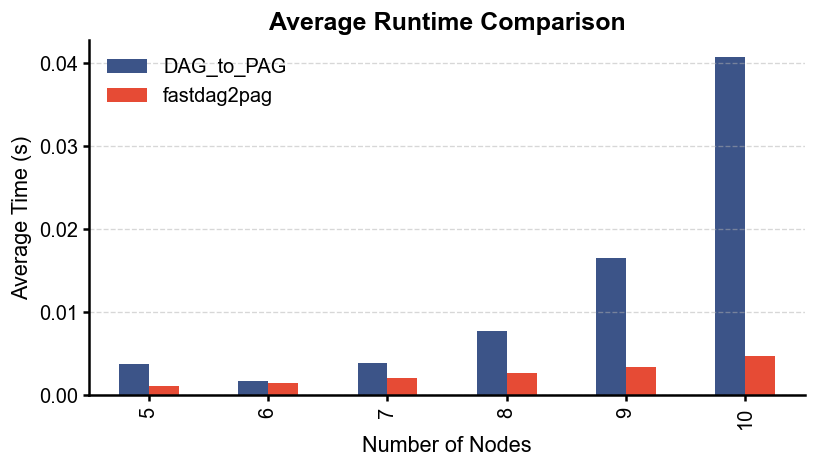

In [2]:
# Plot the average runtime comparison between the two methods
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

# Nature-style color palette
nature_colors = ['#3C5488', '#E64B35']
ax = results_df.plot(x='nodes', y=['dag_to_pag_avg_time', 'fastdag2pag_avg_time'], kind='bar',
                    color=nature_colors,
                    edgecolor='none',
                    figsize=(7,4),
                    legend=True)
ax.set_ylabel('Average Time (s)', fontsize=13, fontname='Arial')
ax.set_xlabel('Number of Nodes', fontsize=13, fontname='Arial')
ax.set_title('Average Runtime Comparison', fontsize=15, fontweight='bold', fontname='Arial')
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.legend(['DAG_to_PAG', 'fastdag2pag'], fontsize=12, frameon=False)
ax.set_xticklabels(results_df['nodes'], rotation=90, fontsize=12, fontname='Arial')
ax.tick_params(axis='y', labelsize=12, width=1.5)
ax.tick_params(axis='x', width=1.5)
# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [2]:
# Test the orientation rules implementation correctness
import numpy as np
import pandas as pd
import time
from DAGtoPAGPython.DAG_to_PAG import DAG_to_PAG
from fastdag2pag.dag2pag import dag2pag
from fastdag2pag.Random_Graph import ErdosRenyi
import matplotlib.pyplot as plt

def binarize_adj(adj: pd.DataFrame) -> pd.DataFrame:
    """Convert all nonzero elements of the adjacency matrix to 1, keep 0 unchanged."""
    adj = adj.copy()
    return (adj != 0).astype(int)

def causal_learn_to_pcalg(adj: pd.DataFrame) -> pd.DataFrame:
    """
    Convert a causal-learn style adjacency matrix to pcalg style.
    causal-learn: TAIL=-1, ARROW=1, CIRCLE=2, NULL=0
    pcalg:        TAIL=3,  ARROW=2, CIRCLE=1, NULL=0
    """
    adj = adj.copy()
    mapping = {-1: 3, 1: 2, 2: 1, 0: 0}
    return adj.replace(mapping)

from fastdag2pag.Graph_utils import Mark
import networkx as nx

def check_no_circle_marks_in_diff(diff, adj, selection_bias_nodes, pagcausallearn, mypag):

    vars_list = adj.columns.to_list()
    DAG = nx.DiGraph(adj)
    ancList = {}
    for var in vars_list:
        ancList[var] = set(nx.ancestors(DAG, var))
    anclist_S = set()
    for s in selection_bias_nodes:
        anclist_S |= ancList[s]

    for row_label in diff.index:
        for col_label in diff.columns:
            value = diff.at[row_label, col_label]
            rmark_symbol = {Mark.TAIL.value: "-", Mark.ARROW.value: ">", Mark.CIRCLE.value: "o"}
            lmark_symbol = {Mark.TAIL.value: "-", Mark.ARROW.value: "<", Mark.CIRCLE.value: "o"}
            # If the value is not a known mark, log a warning and skip
            if value not in rmark_symbol:
                # print(f"Warning: unknown mark value={value} at row={row_label}, col={col_label}")
                continue

            if col_label[1]=='causallearn_pag':
                print(f' {col_label[1]}: {row_label}{lmark_symbol[pagcausallearn.loc[col_label[0],row_label]]}-{rmark_symbol[value]}{col_label[0]}')
            if col_label[1]=='my_pag':
                print(f' {col_label[1]}: {row_label}{lmark_symbol[mypag.loc[col_label[0],row_label]]}-{rmark_symbol[value]}{col_label[0]}')
            if value != Mark.CIRCLE.value:
                # check the mark in the DAG
                if value == Mark.ARROW.value:
                    # means col_label[0] is not an ancetor of {row_label} and S
                    if (col_label[0] not in ancList[row_label]) and (col_label[0] not in anclist_S):
                        print(f"{col_label[1]} correct")
                    else:
                        print(f"Error in {col_label[1]}: {col_label[0]} is an ancestor of {row_label} or S")
                    

                if value == Mark.TAIL.value:
                    # means col_label[0] is an ancetor of {row_label} or S
                    if (col_label[0] in ancList[row_label]) or (col_label[0] in anclist_S):
                        print(f"{col_label[1]} correct")

                    else:
                        print(f"Error in {col_label[1]}: {col_label[0]} is not an ancestor of {row_label} or S")


node_sizes = [10]
num_trials = 10
results = []

for n_nodes in node_sizes:
    dag2pag_times = []
    dag_to_pag_times = []
    match_count = 0
    ER_graph_gen = ErdosRenyi(n_nodes, expected_degree=2, def_dataframe=True, seed=321)
    for trial in range(num_trials):
        # Generate random DAG adjacency matrix
        graph = ER_graph_gen.get_random_graph()
        num_latent = int(n_nodes * 0.1) if n_nodes >= 10 else 1
        num_sel = num_latent  # For simplicity, set number of selection bias nodes equal to number of latent nodes
        adj = ER_graph_gen.set_latent_nodes(graph, num_latent=num_latent, selection_bias=True, num_sel=num_sel)
        latent_nodes = [node for node in adj.columns if node.startswith('L')]
        selection_bias_nodes = [node for node in adj.columns if node.startswith('S')]

        # DAG_to_PAG (causal-learn)
        t0 = time.time()
        pag1 = DAG_to_PAG(adj, latent_nodes=latent_nodes, selection_bias_nodes=selection_bias_nodes)
        t1 = time.time()
        dag_to_pag_times.append(t1 - t0)
        pag1 = causal_learn_to_pcalg(pag1)  # Convert to pcalg style

        # FastDAG2PAG
        t2 = time.time()
        pag2 = dag2pag(adj, latent_nodes=latent_nodes, selection_bias=selection_bias_nodes)['PAG.DataFrame']
        t3 = time.time()
        dag2pag_times.append(t3 - t2)

        # Compare outputs (matrix equality, ignoring edge marks)
        skele_pag1 = binarize_adj(pag1)
        skele_pag2 = binarize_adj(pag2)
        if skele_pag1.equals(skele_pag2):
            match_count += 1
        else:
            print(f"Discrepancy found in graph {n_nodes}-{trial+1}")
            skele_diff = skele_pag1.compare(skele_pag2, result_names=("DAG_to_PAG", "fastdag2pag"))
            print(skele_diff)

        # Check no circle marks in the difference
        diff_marks = pag1.compare(pag2, result_names=("causallearn_pag", "my_pag"))
        print(f"the trial == {trial+1} diff marks:")
        check_no_circle_marks_in_diff(diff_marks, adj, selection_bias_nodes, pag1, pag2)

    results.append({
        'nodes': n_nodes,
        'dag_to_pag_avg_time': np.mean(dag_to_pag_times),
        'fastdag2pag_avg_time': np.mean(dag2pag_times),
        'match_ratio': match_count / num_trials
    })

results_df = pd.DataFrame(results)
print('Match ratio (PAG matrix equality) for each node size:')
for index, row in results_df.iterrows():
    print(f"Node Size: {row['nodes']}, Match Ratio: {row['match_ratio']:.2f}")


the trial == 1 diff marks:

the trial == 2 diff marks:

the trial == 3 diff marks:

the trial == 4 diff marks:

the trial == 5 diff marks:

the trial == 6 diff marks:

the trial == 7 diff marks:
 causallearn_pag: V7o-oV6
 my_pag: V7o->V6
my_pag correct

Find uncovered circle path between A and B: V3 o-o V7
Path:  ['V6', 'V8', 'V9']
Orienting edge A - C (Double tail): V3 --- V6
Orienting edge B - D (Double tail): V7 --- V9
Orienting edge (Double tail): V6 --- V8
Orienting edge (Double tail): V8 --- V9
the trial == 8 diff marks:
 causallearn_pag: V3---V6
causallearn_pag correct
 my_pag: V3o-oV6
 causallearn_pag: V3---V7
causallearn_pag correct
 my_pag: V3o-oV7
 causallearn_pag: V3---V8
causallearn_pag correct
 my_pag: V3o-oV8
 causallearn_pag: V4o--V3
causallearn_pag correct
 my_pag: V4o-oV3
 causallearn_pag: V4o--V6
causallearn_pag correct
 my_pag: V4o-oV6
 causallearn_pag: V4o--V8
causallearn_pag correct
 my_pag: V4o-oV8
 causallearn_pag: V6---V3
causallearn_pag correct
 my_pag: V6o-o